# Example of NLP analysis using BERT


BERT is a transformer model widely used for NLP applications.
Transformers use attention mechanism, that is, for each output
element the model focuses on the most relevant element of the input sequence.

Let's use BERT to classify the IMDB dataset


In [1]:
!pip install -q -U tensorflow-text



     |████████████████████████████████| 4.4 MB 5.4 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 47.6 MB 34 kB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 596 kB 37.4 MB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 
     |████████████████████████████████| 352 kB 45.8 MB/s 
     |████████████████████████████████| 213 kB 45.3 MB/s 
     |████████████████████████████████| 1.1 MB 38.7 MB/s 


In [3]:
import os
import shutil   #to handle folders and files

import tensorflow as tf   #TF for the model
import tensorflow_hub as hub
import tensorflow_text as text  #BERT
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt #plots



In [4]:
#Let's download the data

dataset = tf.keras.utils.get_file(fname = 'aclImdb_v1.tar.gz', #name of file
                                  origin = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', #url of data
                                  untar=True, #decompress
                                  cache_dir='.', #location where to save files
                                  cache_subdir='') #if a subdir wants to be used to save files


84140032/84125825 [==============================] - 2s 0us/step


In [5]:
#Here's where we saved the data
print(dataset)
type(dataset)

./aclImdb_v1


str

In [6]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
#Let's create the dataset 

AUTOTUNE = tf.data.AUTOTUNE   #AUTOTUNE automatically chooses the prefetch size
batch_size = 32
seed = 42

#text_dataset_from_directory() creates a tf.dataset object from text data

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory = 'aclImdb/train',
    batch_size= batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory = 'aclImdb/train',
    batch_size= batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory = 'aclImdb/test',
    batch_size= batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
#Lets take a look

for text,label in train_ds.take(1):
  print(text)
  print(label)

tf.Tensor(
[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicat

In [9]:
print(label.shape)
#batch size of 32

(32,)


Now let's choose the model. For simplicity and quicker transfer learning, let's use the small BERT

In [10]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [11]:
#Now let's create a Keras layer from BERT, it'll preprocess the text
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_preprocess_model

This layer will preprocess text into numeric token ids that BERT can use

In [12]:
text_test = ['Scott Pilgrim vs The World is arguibly the best movie ever made!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}') #These are the outputs of BERT
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')  #This model uses 128 tokens. It can be changed.
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')  #input_type_ids = 0 because it's only one sentence. 

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  3660 21214  5443  1996  2088  2003 12098 25698  6321  1996  2190]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
#Now let's load the model
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_model

In [14]:
#Let's see how BERT works

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')  #pooled outputs represents each input sequence as a whole
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}') #represents each input token 
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.8139333   0.9725887  -0.09539495  0.4074699   0.4156943   0.58910555
  0.9875329  -0.8744342  -0.61655974 -0.99647325 -0.05070589 -0.9834896 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.41341254  0.57676375  1.1466831  ...  0.2556432   0.63392854
   0.5772833 ]
 [-0.8368021  -0.05040655  0.38373008 ... -0.69041836 -0.41695172
   1.0871625 ]
 [-1.0310302   0.48201695  0.5078027  ...  0.5246184   1.1085695
   1.112812  ]
 ...
 [ 0.06234139  0.15692583 -0.11551428 ...  0.55171484  0.3569725
   0.33495867]
 [-0.59916675 -0.25806558 -0.478536   ... -0.7580522   1.2123417
   0.19126403]
 [-1.4004577  -1.311332    0.6158085  ... -0.09202186  0.07924096
   0.06534166]]


## Now let's build the model!

Now that we have the preprocessing layer and the model, let's put them together with a Dropout layer for a bit of regularization and classifying layer for transfer learning

In [15]:
InputLayer = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'text') #input layer of undefined length

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') #preprocessing layer

encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') #encoding layer

#Now let's unite them
encoder_inputs = preprocessing_layer(InputLayer)
encoder_output = encoder(encoder_inputs)
net = encoder_output['pooled_output'] #We only need the pooled output result
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation=None, name='classifier' )(net)

model = tf.keras.Model(InputLayer, net) #this creates the model


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [18]:
#Be careful! the model input should be a tensor
#result = model(text_test)
#print(tf.sigmoid(result))

TypeError: ignored

In [19]:
result = model(tf.constant(text_test))
print(tf.sigmoid(result))

tf.Tensor([[0.7183796]], shape=(1, 1), dtype=float32)


## Transfer Learning

Now we're ready to do some transfer learning for BERT

First, we choose the same optimizer that was used for the creation of BERT

In [20]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy() #the size of the training set
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [21]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [22]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 309s 482ms/step - loss: 0.4865 - binary_accuracy: 0.7445 - val_loss: 0.4109 - val_binary_accuracy: 0.8288
Epoch 2/5
625/625 [==============================] - 295s 472ms/step - loss: 0.3302 - binary_accuracy: 0.8537 - val_loss: 0.3841 - val_binary_accuracy: 0.8424
Epoch 3/5
625/625 [==============================] - 294s 471ms/step - loss: 0.2535 - binary_accuracy: 0.8952 - val_loss: 0.3984 - val_binary_accuracy: 0.8456
Epoch 4/5
625/625 [==============================] - 293s 468ms/step - loss: 0.1909 - binary_accuracy: 0.9263 - val_loss: 0.4278 - val_binary_accuracy: 0.8518
Epoch 5/5
625/625 [==============================] - 291s 465ms/step - loss: 0.1537 - binary_accuracy: 0.9430 - val_loss: 0.4669 - val_binary_accuracy: 0.8500


In [23]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 165s 211ms/step - loss: 0.4503 - binary_accuracy: 0.8577
Loss: 0.4502917230129242
Accuracy: 0.8576800227165222


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


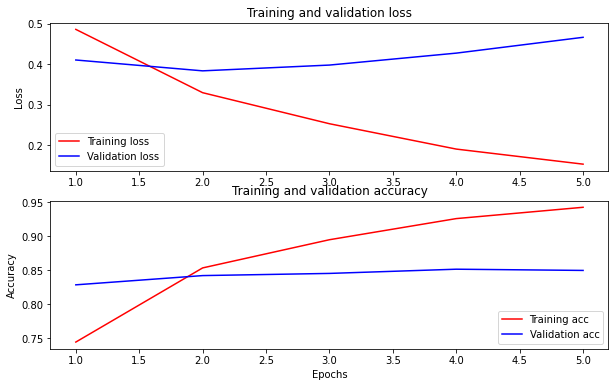

In [24]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')